# Цель работы

**Цель** - собрать единый отчет по работе всего приложения. В отчете должна быть информация и по ленте новостей, и по сервису отправки сообщений.

**Идея** - загрузить данные с Clickhouse, выбрать основные метрики и собрать отчет, который в последствии будет приходит в чате в телеграмме каждое утро.

**Задачи**:

1. Возьмем основные метрики - DAU (по ленте новостей и мессенджеру), Просмотры, Лайки, CTR, Количество сообщений.
2. Напишем функцию для создания сообщения с информацией о значениях ключевых метрик за предыдущий день.
3. Затем функцию для графиков - отобразим последние 7 дней, чтобы лучше было видно динамику.
4. Отправляем данные в чат.

*Сам скрипт DAGа в конце*

# Автоматизация отчетов

## Загрузка необходимых элементов для бота

In [2]:
# Загружаем необходимые библиотеки
import datetime
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse

In [3]:
# Получаем доступ к боту

my_token = '6245347830:AAHFIuYvAh9YxKR4taSMoQHNA0GuelpvUrA' # токен
bot = telegram.Bot(token=my_token)

In [7]:
# Получаем необходимый ID
updates = bot.getUpdates()
chat_id = 1013581629
print(updates[-1])

{'update_id': 406440361, 'my_chat_member': {'chat': {'title': 'ОТЧЕТЫ | Симулятор аналитика karpov.courses', 'id': -802518328, 'type': 'group', 'all_members_are_administrators': False}, 'old_chat_member': {'status': 'left', 'user': {'is_bot': True, 'first_name': 'Daily_report', 'username': 'daily_report_grr_bot', 'id': 6245347830}, 'until_date': None}, 'new_chat_member': {'status': 'member', 'user': {'is_bot': True, 'first_name': 'Daily_report', 'username': 'daily_report_grr_bot', 'id': 6245347830}, 'until_date': None}, 'date': 1682060339, 'from': {'is_bot': False, 'last_name': 'Григораш', 'first_name': 'Катерина', 'username': 'katringrr', 'language_code': 'ru', 'id': 1013581629}}}


In [54]:
# Устанавливаем свзять с ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

## Отчет по ленте новостей и мессенджеру

In [105]:
# Запрос на (1) кол-во смс, (2) просмотры, (3) лайки, (4) CTR за вчера
query_1 = '''
            SELECT
                    date,
                    DAU_news,
                    CTR,
                    DAU_mes,
                    messages_on_users
            FROM
                (SELECT
                    toDate(time) as date,
                    sum(action = 'like') as likes,
                    count(DISTINCT(user_id)) as DAU_news,
                    sum(action = 'view') as views,
                    likes / views as CTR
                FROM simulator_20230320.feed_actions 
                WHERE (toDate(date) > today() - 7) AND (toDate(date) != today())
                GROUP BY date) n

            JOIN

                (SELECT
                    toDate(time) as date,
                    count(DISTINCT(user_id)) as DAU_mes,
                    count(user_id) as messages_sent,
                    DAU_mes / messages_sent as messages_on_users
                FROM simulator_20230320.message_actions
                WHERE (toDate(date) > today() - 7) AND (toDate(date) != today())
                GROUP BY date) m
                

            USING date
            ORDER BY date
            '''
data = pandahouse.read_clickhouse(query_1, connection=connection)

In [106]:
# Пользователи по использованию (1) ленты, (2) мессенджера, (3) и того и другого
query_2 = '''
            SELECT
                    date,
                    sum(using_app = 'only news') as only_news,
                    sum(using_app = 'only messages') as only_messages,
                    sum(using_app = 'both') as both
            FROM    (SELECT
                            date,
                            multiIf (messages = 0, 'only news', 
                                     news_action = 0, 'only messages', 
                                     'both') as using_app
                    FROM
                            (SELECT
                                    user_id,
                                    count(post_id) as news_action,
                                    toDate(time) as date
                            FROM simulator_20230320.feed_actions
                            WHERE (toDate(time) > today() - 7) AND (toDate(time) != today())
                            GROUP BY user_id, date) n


                        FULL JOIN

                            (SELECT
                                    user_id,
                                    count(reciever_id) as messages,
                                    toDate(time) as date
                            FROM simulator_20230320.message_actions
                            WHERE (toDate(time) > today() - 7) AND (toDate(time) != today())
                            GROUP BY user_id, date) m

                        USING user_id, date)

            GROUP BY date
            ORDER BY date
            '''
data_2 = pandahouse.read_clickhouse(query_2, connection=connection)

In [108]:
    date = data.date[5].strftime('%d.%m.%Y')
    msg_date = f'*Аналитика за {date}*'
    
    ## Cоздаем сообщения
    # DAU (лента новостей)
    msg_DAU_n = f'DAU (лента новостей): {data.DAU_news[5]}'
    # DAU (мессенджер)
    msg_DAU_m = f'DAU (мессенджер): {data.DAU_mes[5]}'
    # CTR (просмотры на лайки)
    msg_CTR = f'CTR (просмотры на лайки): {round(data.CTR[5], 2)}'
    # Среднее число смс на пользователя
    msg_mou = f'Среднее число смс на польз.: {round(data.messages_on_users[5], 2)}'
    
    # Только ленту новостей
    msg_on = f'только ленту новостей: {data_2.only_news[5]}'
    # Только мессенджер
    msg_om = f'только мессенджер: {data_2.only_messages[5]}'
    # И ленту новостей и мессенджер
    msg_nam = f'и ленту новостей и мессенджер: {data_2.both[5]}'
    # Объединяем
    msg = msg_date + '\n\n' + \
          msg_DAU_n + '\n' + \
          msg_DAU_m + '\n' + \
          msg_CTR + '\n' + \
          msg_mou + '\n\n' + \
          'Пользователи, использующие:' + '\n' + \
          '- '+ msg_on + '\n' + \
          '- '+ msg_om + '\n' + \
          '- '+ msg_nam
    
    print(msg)

*Аналитика за 19.04.2023*

DAU (лента новостей): 18585
DAU (мессенджер): 2097
CTR (просмотры на лайки): 0.2
Среднее число смс на польз.: 0.16

Пользователи, использующие:
- только ленту новостей: 18333
- только мессенджер: 1845
- и ленту новостей и мессенджер: 252


## Графики

In [110]:
# Запрос на (1) кол-во смс, (2) просмотры, (3) лайки, (4) CTR за последние 7 дней
query_7_1 = '''
            SELECT
                    date,
                    DAU_news,
                    likes,
                    views,
                    CTR,
                    DAU_mes,
                    messages_sent,
                    messages_on_users
            FROM
                (SELECT
                    toStartOfHour(time) as date,
                    sum(action = 'like') as likes,
                    count(DISTINCT(user_id)) as DAU_news,
                    sum(action = 'view') as views,
                    likes / views as CTR
                FROM simulator_20230320.feed_actions 
                WHERE (toDate(date) > today() - 7) AND (toDate(date) != today())
                GROUP BY date) n

            JOIN

                (SELECT
                    toStartOfHour(time) as date,
                    count(DISTINCT(user_id)) as DAU_mes,
                    count(user_id) as messages_sent,
                    DAU_mes / messages_sent as messages_on_users
                FROM simulator_20230320.message_actions
                WHERE (toDate(date) > today() - 7) AND (toDate(date) != today())
                GROUP BY date) m
                

            USING date
            ORDER BY date
            '''
data_7_1 = pandahouse.read_clickhouse(query_7_1, connection=connection)

In [111]:
query_7_2 = '''
            SELECT
                    date,
                    sum(using_app = 'only news') as only_news,
                    sum(using_app = 'only messages') as only_messages,
                    sum(using_app = 'both') as both
            FROM    (SELECT
                            date,
                            multiIf (reciever_id = 0, 'only news', 
                                     post_id = 0, 'only messages', 
                                     'both') as using_app
                    FROM
                            (SELECT
                                    user_id,
                                    post_id,
                                    toStartOfHour(time) as date
                            FROM simulator_20230320.feed_actions
                            WHERE (toDate(time) > today() - 7) AND (toDate(time) != today())) n


                        FULL JOIN

                            (SELECT
                                    user_id,
                                    reciever_id,
                                    toStartOfHour(time) as date
                            FROM simulator_20230320.message_actions
                            WHERE (toDate(time) > today() - 7) AND (toDate(time) != today())) m

                        USING user_id, date)

            GROUP BY date
            '''
data_7_2 = pandahouse.read_clickhouse(query_7_2, connection=connection)

NameError: name 'data_7' is not defined

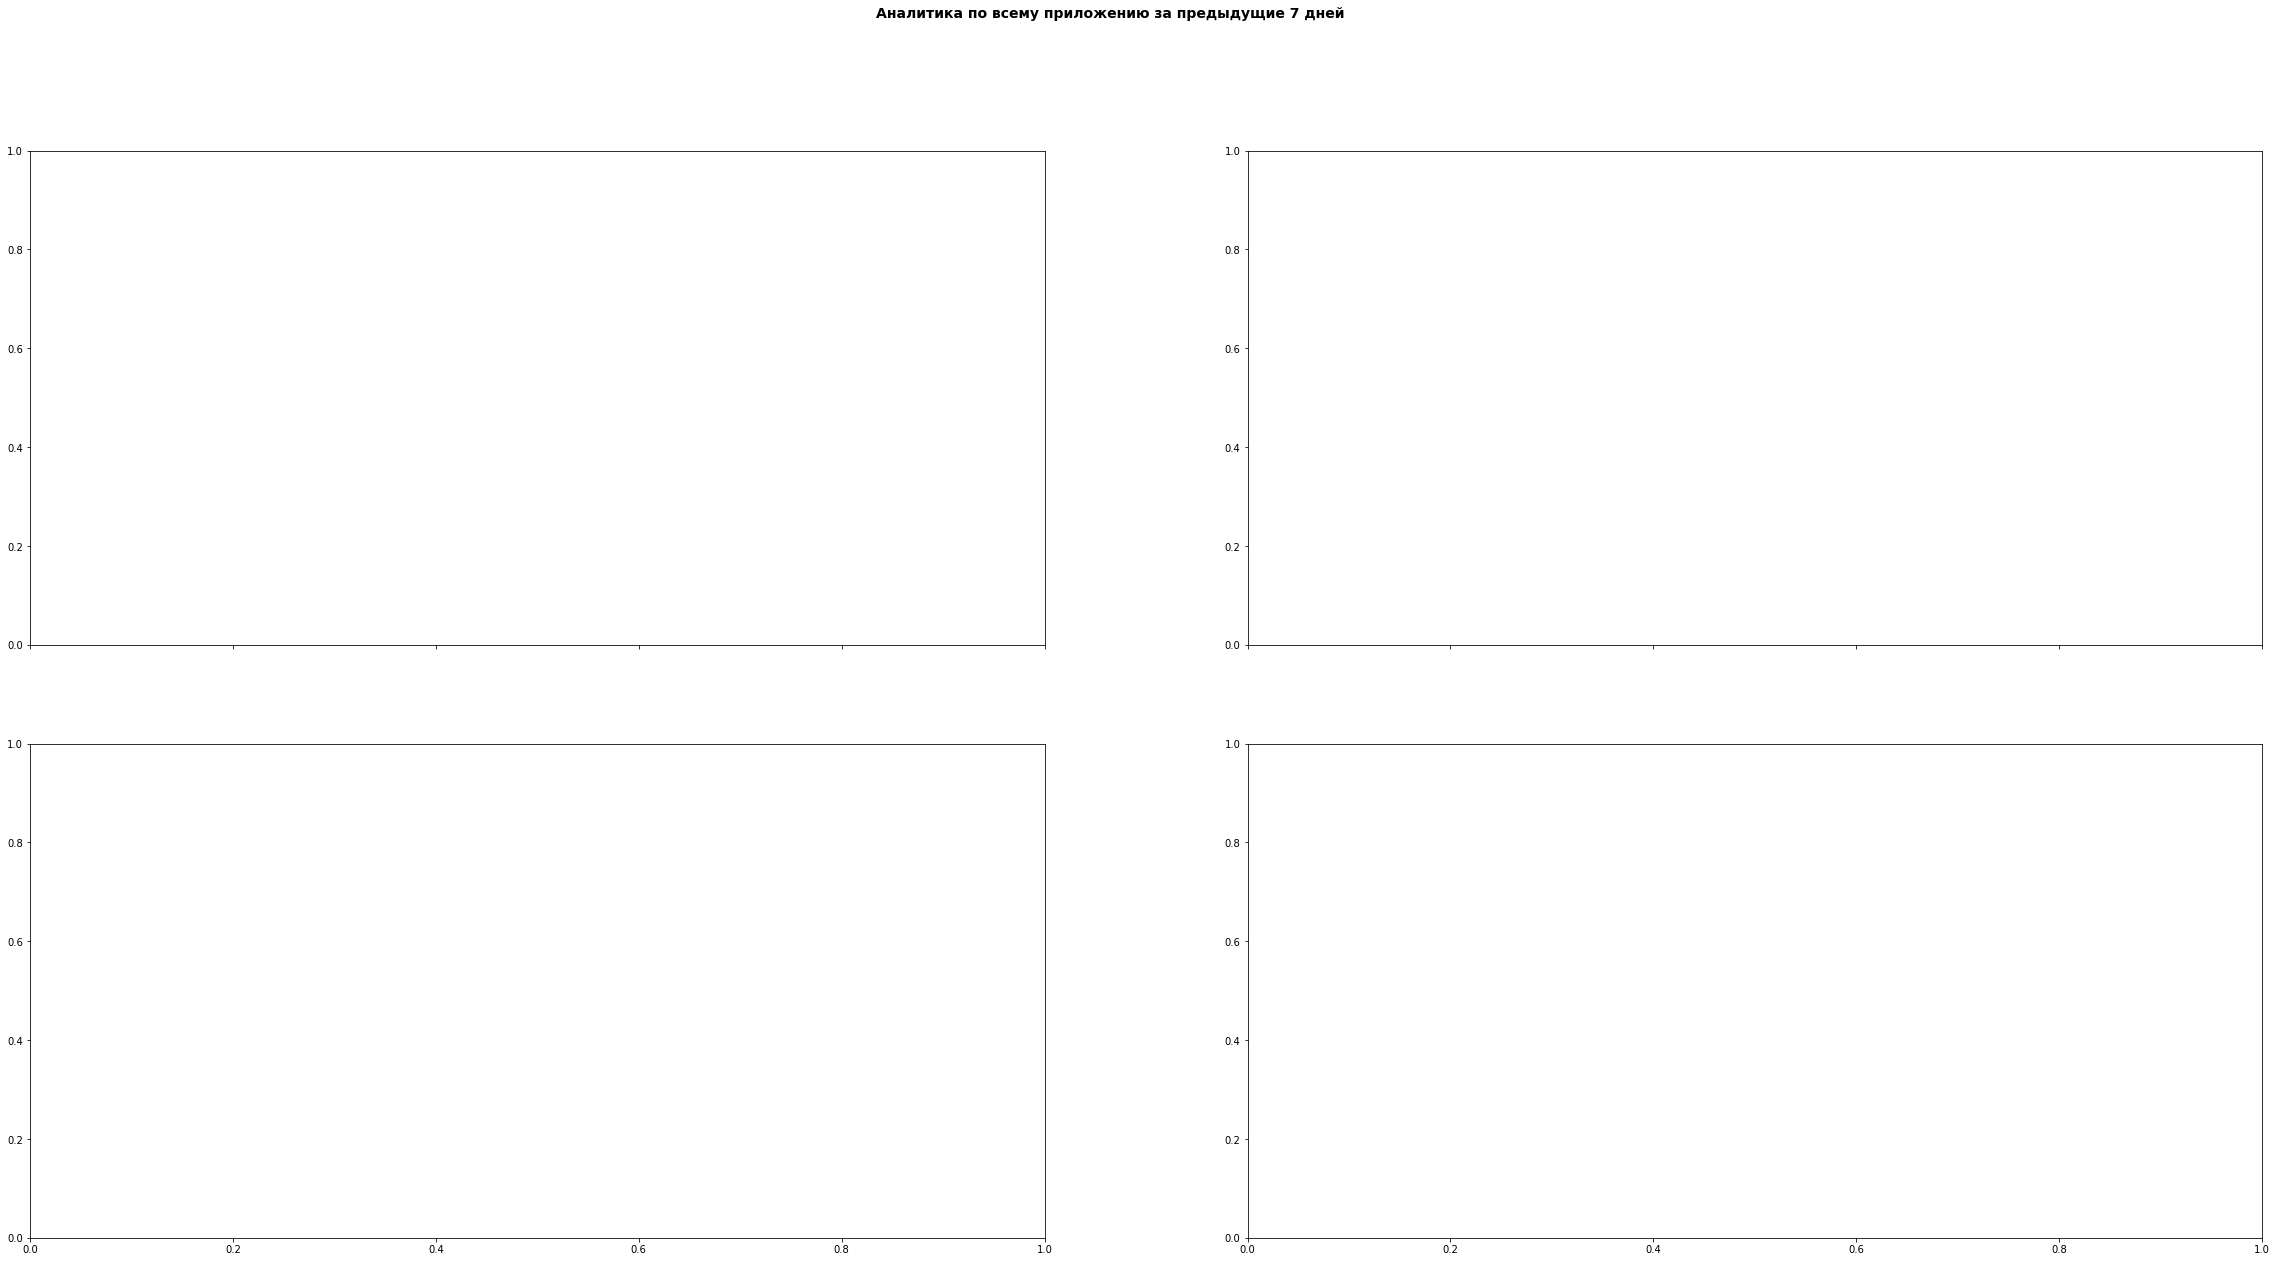

In [8]:
    # Создаем настройки для объединения графиков
    fig, ax = plt.subplots(2, 2, figsize=(40, 20), sharex=True)
    fig.suptitle(f'Аналитика по всему приложению за предыдущие 7 дней', fontweight='bold',fontsize=14)
    sns.set_style("whitegrid")
    
    # Задаем позиции
    ax_1 = ax[0, 0]
    ax_2 = ax[0, 1]
    ax_3 = ax[1, 0]
    ax_4 = ax[1, 1]


    ## DAU (лента новостей)
    # Создаем график
    sns.lineplot(data=data_7, x='date', y='DAU_news', ax=ax_1)
    # Добавляем подписи
    ax_1.set_title(f'DAU (лента новостей)', fontsize=12)
    ax_1.set_xlabel('Даты')
    ax_1.set_ylabel('Кол-во уник. польз.')
    
    ## DAU (мессенджер)
    # Создаем график
    sns.set_style("whitegrid")
    sns.lineplot(data=data_7, x='date', y='DAU_mes', ax=ax_3)
    # Добавляем подписи
    ax_3.set_title(f'DAU (мессенджер)', fontsize=12)
    ax_3.set_xlabel('Даты')
    ax_3.set_ylabel('Кол-во уник. польз.')
    
    ## Среднее число смс на пользователя
    # Создаем график
    sns.set_style("whitegrid")
    sns.lineplot(data=data_7, x='date', y='messages_on_users', ax=ax_4)
    # Добавляем подписи
    ax_4.set_title(f'Среднее число смс на пользователя', fontsize=12)
    ax_4.set_xlabel('Даты')
    ax_4.set_ylabel('Кол-во уник. польз.')
    
    ## CTR (просмотры на лайки)
    # Создаем график
    sns.lineplot(data=data_7, x='date', y='CTR',ax=ax_2)
    # Добавляем подписи
    ax_2.set_title(f'CTR (просмотры на лайки)', fontsize=12)
    ax_2.set_xlabel('Даты')
    ax_2.set_ylabel('CTR')

Text(0, 0.5, 'Кол-во уник. польз.')

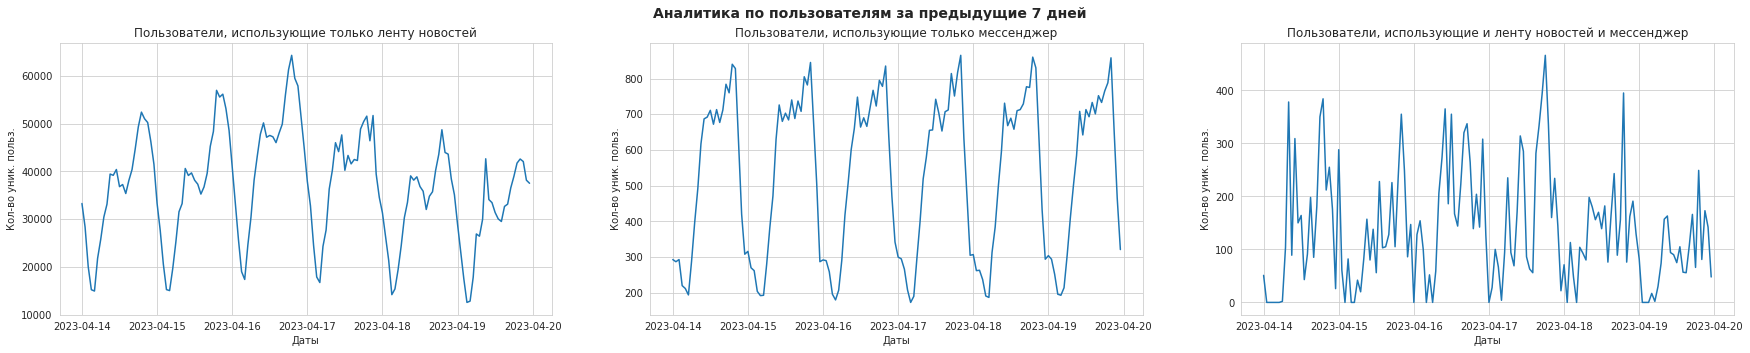

In [117]:
    # Создаем настройки для объединения графиков
    fig, ax = plt.subplots(1, 3, figsize=(30, 5), sharex=True)
    fig.suptitle(f'Аналитика по пользователям за предыдущие 7 дней', fontweight='bold',fontsize=14)
    sns.set_style("whitegrid")
    
    # Задаем позиции
    ax_1 = ax[0]
    ax_2 = ax[1]
    ax_3 = ax[2]
    
    ## Пользователи, использующие только ленту новостей
    # Создаем график
    sns.lineplot(data=data_7_2, x='date', y='only_news', ax=ax_1)
    # Добавляем подписи
    ax_1.set_title(f'Пользователи, использующие только ленту новостей', fontsize=12)
    ax_1.set_xlabel('Даты')
    ax_1.set_ylabel('Кол-во уник. польз.')
    
    ## Пользователи, использующие только мэссенджер
    # Создаем график
    sns.set_style("whitegrid")
    sns.lineplot(data=data_7_2, x='date', y='only_messages', ax=ax_2)
    # Добавляем подписи
    ax_2.set_title(f'Пользователи, использующие только мессенджер', fontsize=12)
    ax_2.set_xlabel('Даты')
    ax_2.set_ylabel('Кол-во уник. польз.')
    
    ## Пользователи, использующие и ленту новостей и мессенджер
    # Создаем график
    sns.set_style("whitegrid")
    sns.lineplot(data=data_7_2, x='date', y='both', ax=ax_3)
    # Добавляем подписи
    ax_3.set_title(f'Пользователи, использующие и ленту новостей и мессенджер', fontsize=12)
    ax_3.set_xlabel('Даты')
    ax_3.set_ylabel('Кол-во уник. польз.')

# Код Дага